# Bayesian Neural Networks (BNNs)

In this notebook a Bayesian Neural network is trained on the CFB data to take bridge parameter as input an predict the code compliance factors.

### Resources
Here you can find nice explanations: 

1. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html

The following source was used as a stating point for the implementation:

2. https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825 

### Content
1. Data Import
2. Data Pre-processing
3. Setup and Train Model
4. Model Perfromance Evaluation
5. 1D Parameter Studies


In [1]:
#import necessary libraries
import pandas as pd
import math as m
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

## 1.  Data Import 

Data is imported from the defined csv file to a pandas Data Frame.

In [2]:
# Define path to csv-file
file_path="trainingData\\1000_CFB_xy.csv"

#import data from csv file
df = pd.read_csv(file_path)
# df

## 2. Pre-process Data

Pre-Processing Steps
- select x and y columns (inputs and outputs)
- split data set in training and test set
- transform data to same range with MinMaxScaler
- transform scaled data to torch tensors

In [3]:
###### select input and ouputs ######

#x_names = ['L', 'b1',  't_p', 't_w', 'h_w'] #5 important features
x_names = ['L', 'b1',  't_p', 't_w', 'h_w', 'd1_plate', 'd4_plate', 'd2_plate', 's_plate', 'd1_walls', 'd4_walls', 's_walls', 'fcc', 's', 'beta', 'h_G'] # all 16 features
# Select perfromances
y_names=['eta_min_c']


# Get relevant columns and transorm to torch tensors
x_data_df=df[x_names]
y_data_df=df[y_names]


In [4]:
####### data set split #######

#define test split size:
test_size = 0.2
# split the data in training and test set
x_train_df, x_val_df, y_train_df, y_val_df = train_test_split(x_data_df, y_data_df, test_size=test_size, random_state=42)

# transfrom to numpy arrays
x_train_np = x_train_df.values
y_train_np = y_train_df.values
x_val_np = x_val_df.values
y_val_np = y_val_df.values

print(x_train_df.shape)



(8000, 16)


In [5]:
###### Scaling of data ######

# Initialize the MinMaxScaler and fit it on the training data
# Note: MinMaxScaler  scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
# Note: MinMaxScaler doesn’t reduce the effect of outliers, but it linearly scales them down into a fixed range
scaler = MinMaxScaler(feature_range=(0, 1))

# scale training data
x_train_scaled_np = scaler.fit_transform(x_train_df)
x_train_scaled_df=pd.DataFrame(data=x_train_scaled_np, columns=scaler.get_feature_names_out())
# print(x_train_scaled_df)

# Scale the validation data using the same scaler
x_val_scaled_np = scaler.transform(x_val_df)
x_val_scaled_df=pd.DataFrame(data=x_val_scaled_np, columns=scaler.get_feature_names_out())

In [6]:
##### convert to troch tensors ######

# convert data to toch tensors (as needed format for BNN model)
x_train_scaled_tensor=torch.tensor(x_train_scaled_df.values, dtype=torch.float32)
y_train_tensor=torch.tensor(y_train_df.values, dtype=torch.float32)

x_val_scaled_tensor=torch.tensor(x_val_scaled_df.values, dtype=torch.float32)
y_val_tensor=torch.tensor(y_val_df.values, dtype=torch.float32)


## 3. Setup and Train Model

- Define NN Architecture
- Define Losses
- Trianing Loop
- Plot loss developement during trianing
- save trained model

In [7]:
# define NN architecture
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=200),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=200),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=200),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=200),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=1)
)


#initialize error tracking lists
#TODO I think these need to be new initialised when the model is redefined. 
# Otherwise they should not always be initialised when the training is started. because we could have the case that a pretrained model is trainied for some more epochs.
mse_list=[]
custom_mse_list = []
rmse_list=[]
kl_list=[]


In [8]:
##### Losses ######

# define kl weight for weighing of kl_loss in total loss function
kl_weight = 0.01
# get kl loss
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

# get mse loss
mse_loss = nn.MSELoss()

#define custom loss function
def weighted_mse_loss(predictions, targets, importance_range=(0, 5), high_weight=10):
    # Calculate the basic MSE loss
    basic_mse = (predictions - targets) ** 2

    # Apply a higher weight to errors within the specified range
    weights = torch.ones_like(targets)
    weights[(targets >= importance_range[0]) & (targets <= importance_range[1])] = high_weight

    # Calculate the weighted MSE loss
    weighted_mse = basic_mse * weights
    return weighted_mse.mean()

#get optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [9]:
# define epochs, and the training data
epochs = 1000
x = x_train_scaled_tensor
y = y_train_tensor


#training loop
for step in range(epochs):
    model.train()
    y_pred = model(x)

    #standard mse, rmse loss
    mse = mse_loss(y_pred, y)
    mse_list.append(mse.item())
    rmse = torch.sqrt(mse)
    rmse_list.append(rmse.item())

    # Custom weighted MSE loss
    custom_mse = weighted_mse_loss(y_pred, y, importance_range=(0, 100), high_weight=10)
    custom_mse_list.append(custom_mse.item())

    #kl_divergence loss
    kl = kl_loss(model)
    kl_list.append(kl.item())

    # Add individual losses weighted to single loss
    cost = rmse + kl_weight*kl
    cost_custom = custom_mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost_custom.backward()
    optimizer.step()

    #verbalise
    if step % 100 == 0:
        print(f'Step {step}, MSE: {mse.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, Custom MSE: {custom_mse.item():.2f}')


print('Training is finished. The final losses:') 
print(f'Step {step}, MSE: {mse.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, Custom MSE: {custom_mse.item():.2f}')

Step 0, MSE: 1196.53, KL: 0.11, RMSE: 34.59, Custom MSE: 6002.06
Step 100, MSE: 874.35, KL: 0.36, RMSE: 29.57, Custom MSE: 4147.17
Step 200, MSE: 305.46, KL: 0.44, RMSE: 17.48, Custom MSE: 1147.61
Step 300, MSE: 214.70, KL: 0.50, RMSE: 14.65, Custom MSE: 1084.13
Step 400, MSE: 446.38, KL: 0.55, RMSE: 21.13, Custom MSE: 1718.50
Step 500, MSE: 271.42, KL: 0.59, RMSE: 16.47, Custom MSE: 975.21
Step 600, MSE: 366.04, KL: 0.63, RMSE: 19.13, Custom MSE: 1704.85
Step 700, MSE: 215.45, KL: 0.68, RMSE: 14.68, Custom MSE: 851.37
Step 800, MSE: 261.88, KL: 0.75, RMSE: 16.18, Custom MSE: 925.44
Step 900, MSE: 151.08, KL: 0.79, RMSE: 12.29, Custom MSE: 570.97
Training is finished. The final losses:
Step 999, MSE: 118.34, KL: 0.82, RMSE: 10.88, Custom MSE: 489.81


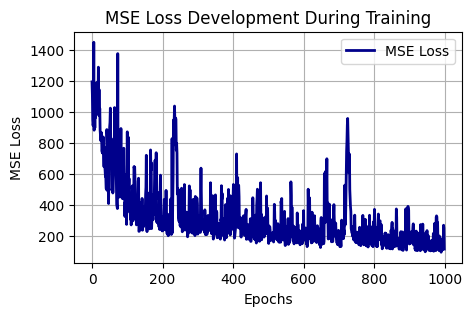

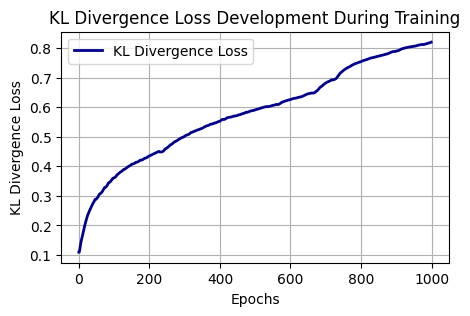

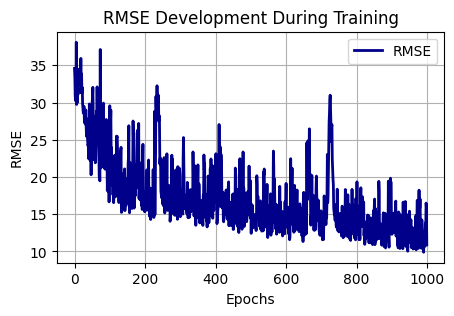

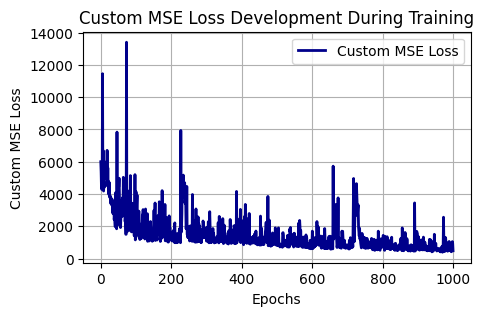

In [10]:
from plotting import plot_loss_development

loss_lists = [mse_list, kl_list, rmse_list, custom_mse_list]
loss_names = ['MSE Loss', 'KL Divergence Loss', 'RMSE', 'Custom MSE Loss']

# Define a path to save the plots, if needed
save_path = 'trainedModels' # Example path, change it as needed

plot_loss_development(loss_lists, loss_names, save_path, color='darkblue', model_name='TestModel', figsize=(5, 3))

In [11]:
####### save model #######
# define model name
name_training_run='RunTestShort'

#saving the whole model
torch.save(model, 'trainedModels\\'+name_training_run+'.pth')

#saving just the weights and biases
#torch.save(model.state_dict(), 'trainedModels\\'+name_training_run+'.pth')

## 4. Model evaluation
- load model
- evaluate prediction perfromance on training data

In [12]:
## load a model
name_training_run='RunTestShort'
model = torch.load('trainedModels\\'+name_training_run+'.pth')
model.eval()
model

C:\Users\bingg\AppData\Local\Temp\ipykernel_25804\1857433879.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('trainedModels\\'+name_training_run+'.pth

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=200, bias=True)
  (1): ReLU()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=200, bias=True)
  (3): ReLU()
  (4): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=200, bias=True)
  (5): ReLU()
  (6): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=200, bias=True)
  (7): ReLU()
  (8): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=1, bias=True)
)

In [13]:
from plotting import plot_true_vs_pred, single_para_strudy_perf
from MLmodel import bnn_predict_with_uncertainty, calculate_rmse, filter_values_within_range

#### On the training data

In [14]:
##### make predictions ####3
# Define number of predictions
n_predictions = 3

# Perfrom multiple predictions on data --> get mean and std for each data point
y_train_mean_pred_np, y_train_std_pred_np = bnn_predict_with_uncertainty(model, x_train_scaled_tensor, n=n_predictions)
# print('Mean Predictions: ', y_train_mean_pred_np)
# print('Standard Deviation of Predictions: ', y_train_std_pred_np)

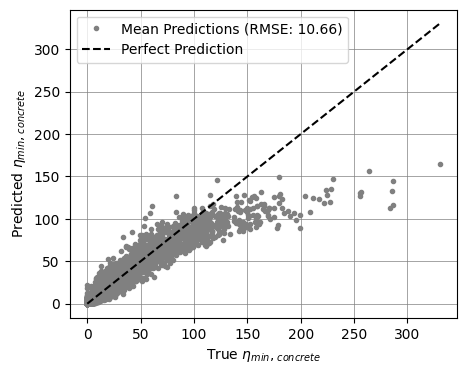

In [15]:
###### Calulate Metrics and Plot #######

# Calculate rmse
rmse_train = calculate_rmse(y_train_np, y_train_mean_pred_np)
# print("Root Mean Squared Error (RMSE):", rmse_train)

#plot True vs Pred Plot
plot_true_vs_pred(y_true=y_train_np, y_pred=y_train_mean_pred_np, rmse_value=rmse_train, y_name='$\eta_{min},_{concrete}$' )

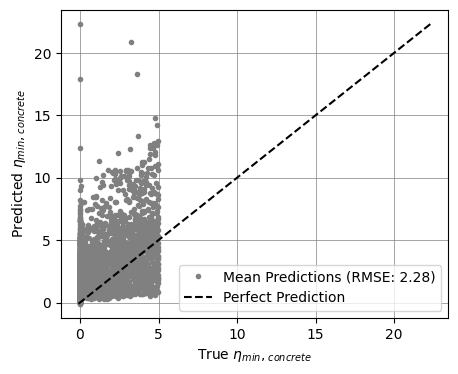

In [16]:
###### Calulate Metrics and Plot: For Critical Range #######

# Define the range
lower_bound = 0
upper_bound = 5

filtered_y_train_np, filtered_y_train_mean_pred_np=filter_values_within_range(y_true=y_train_np, y_pred=y_train_mean_pred_np, lb=lower_bound, ub=upper_bound)

# Calculate rmse
rmse_train_filtered = calculate_rmse(filtered_y_train_np, filtered_y_train_mean_pred_np)

#plot True vs Pred Plot
plot_true_vs_pred(y_true=filtered_y_train_np, y_pred=filtered_y_train_mean_pred_np, rmse_value=rmse_train_filtered, 
                    y_name='$\eta_{min},_{concrete}$' )



### 4.1 On the validation data:

#### 4.1.1 Plots

In [17]:
##### make predictions ####
# Define number of predictions
n_predictions = 3

# Perfrom multiple predictions on data --> get mean and std for each data point
y_val_mean_pred_np, y_val_std_pred_np = bnn_predict_with_uncertainty(model, x_val_scaled_tensor, n=n_predictions)
# y_val_mean_pred_np

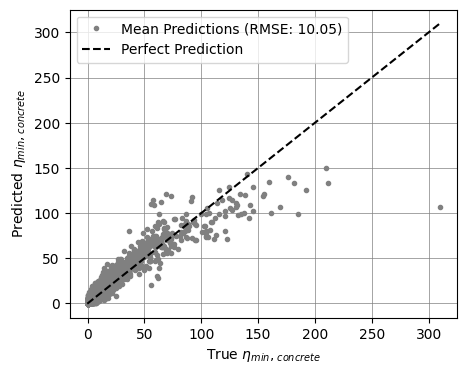

In [18]:
###### Calulate Metrics and Plot #######

# Calculate rmse
rmse_val = calculate_rmse(y_val_np, y_val_mean_pred_np)

#plot True vs Pred Plot
plot_true_vs_pred(y_true=y_val_np, y_pred=y_val_mean_pred_np, rmse_value=rmse_val, y_name='$\eta_{min},_{concrete}$' )

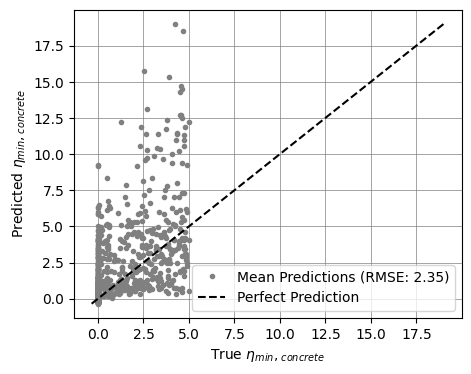

In [19]:
###### Calulate Metrics and Plot: For Critical Range #######

# Define the range
lower_bound = 0
upper_bound = 5

filtered_y_val_np, filtered_y_val_mean_pred_np=filter_values_within_range(y_true=y_val_np, y_pred=y_val_mean_pred_np, lb=lower_bound, ub=upper_bound)

# Calculate rmse
rmse_val_filtered = calculate_rmse(filtered_y_val_np, filtered_y_val_mean_pred_np)

#plot True vs Pred Plot
plot_true_vs_pred(y_true=filtered_y_val_np, y_pred=filtered_y_val_mean_pred_np, rmse_value=rmse_val_filtered, 
                    y_name='$\eta_{min},_{concrete}$' )

#### 4.1.2 Accuracy metrics

In [20]:
def regular_mse(predictions, targets):
    basic_mse = (predictions - targets) ** 2
    return basic_mse.mean()

def regular_rmse(predictions, targets):
    basic_mse = (predictions - targets) ** 2
    mean_squared_diff = np.mean(basic_mse)
    rmse = np.sqrt(mean_squared_diff)
    return rmse

def custom_mse(predictions, targets, importance_range=(0, 5), high_weight=10):
    # Calculate the basic MSE loss
    basic_mse = (predictions - targets) ** 2

    # Apply a higher weight to errors within the specified range
    weights = np.ones_like(targets)
    weights[(targets >= importance_range[0]) & (targets <= importance_range[1])] = high_weight

    # Calculate the weighted MSE loss
    weighted_mse = basic_mse * weights
    return weighted_mse.mean()

In [21]:
regular_mse_val = regular_mse(predictions=y_val_mean_pred_np, targets=y_val_np)
print(f"Regular MSE = {regular_mse_val:.2f}")

regular_rmse_val = regular_rmse(predictions=y_val_mean_pred_np, targets=y_val_np)
print(f"Regular RMSE = {regular_rmse_val:.2f}")

custom_mse_val = custom_mse(predictions=y_val_mean_pred_np, targets=y_val_np)
print(f"Custom MSE = {custom_mse_val:.2f}")

Regular MSE = 100.97
Regular RMSE = 10.05
Custom MSE = 126.79


## 5.  1D Parameter study validation

Here we plot the 1D parameter studies calculated with the parameteric NLFE-Analysis-Pipeline against the mean prediction of the trained BNN model. Additionally we plot the uncertanty of the prediction.

### 5.1 Get features and targets

In [77]:
idx_s1=305
start_id = 0
end_id = 14
step='step_4'
var_par='beta'
unit=' [mm]'

df_xy_1=None

xy_file_name='CFBData\\{}_Batch\\{}_CFB_xy.csv'.format(idx_s1,idx_s1)

df_xy_1=pd.read_csv(xy_file_name)
# df_xy_1[[var_par,'eta_min_s','x_s','y_s','z_s','Location_s','GP_count_s','eta_min_c','x_c','y_c','z_c','Location_c','GP_count_c']]

### 5.2 Forward pass of features in BNN

In [78]:
#Extract features
x_names = ['L', 'b1',  't_p', 't_w', 'h_w', 'd1_plate', 'd4_plate', 'd2_plate', 's_plate', 'd1_walls', 'd4_walls', 's_walls', 'fcc', 's', 'beta', 'h_G'] # all 16 features
x_df=df_xy_1[x_names]

#Scale them
scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled_np = scaler.fit_transform(x_df)
x_scaled_df=pd.DataFrame(data=x_scaled_np, columns=scaler.get_feature_names_out())

#transform into tensor
x_1D_tensor=torch.tensor(x_scaled_df.values, dtype=torch.float32)

In [79]:
##### make predictions ####
# Define number of predictions
n_predictions = 3

# Perfrom multiple predictions on data --> get mean and std for each data point
val_mean_pred_1d, val_std_pred_1d = bnn_predict_with_uncertainty(model, x_1D_tensor, n=n_predictions)


### 5.3 Plot results

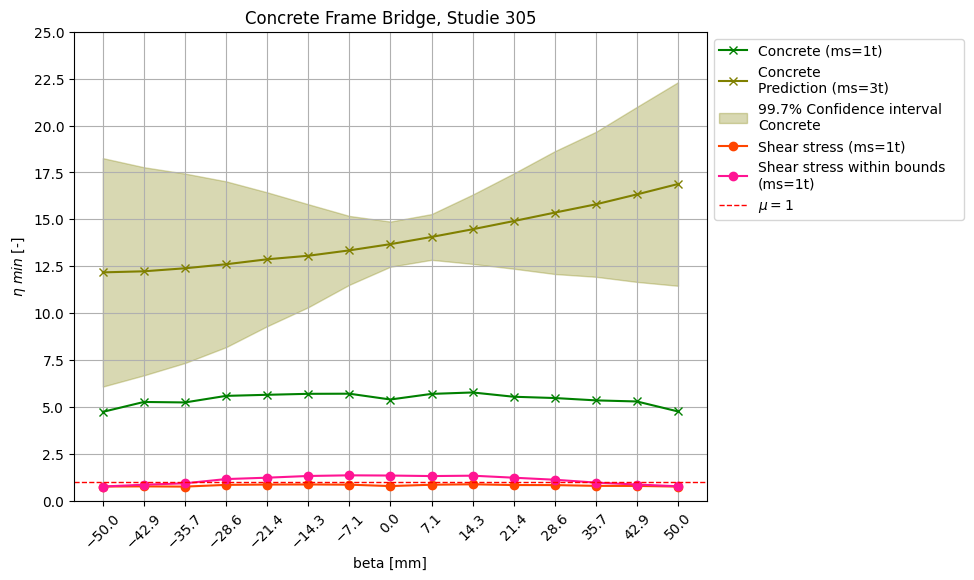

In [81]:
cm = 1/2.54

fig, ax = plt.subplots(figsize=(25*cm,15*cm))

#Bending
ax.plot(df_xy_1[var_par], df_xy_1['eta_min_c'], label='Concrete (ms=1t)', marker='x', color='green')

#Prediction
ax.plot(df_xy_1[var_par], val_mean_pred_1d[:,0], label='Concrete \nPrediction (ms=3t)', marker='x', color='olive')

#Confidence
ax.fill_between(df_xy_1[var_par], val_mean_pred_1d[:,0] - 3*val_std_pred_1d[:,0], val_mean_pred_1d[:,0] + 3*val_std_pred_1d[:,0], label = "99.7% Confidence interval \nConcrete", color = "olive", alpha = 0.3)

#Shear
ax.plot(df_xy_1[var_par], df_xy_1['eta_min_shear'],label='Shear stress (ms=1t)', marker='o', color='orangered')
ax.plot(df_xy_1[var_par], df_xy_1['eta_min_shear_reduced'],label='Shear stress within bounds   \n(ms=1t)', marker='o', color='deeppink')

ax.set(xlabel=var_par+unit, ylabel='$\eta \ min$ [-]',
       title='Concrete Frame Bridge, Studie {}'.format(idx_s1))

upper_lim = 25

ax.set_ylim(bottom=0,top=upper_lim)
ax.axhline(y=1, color='red', linestyle='--', linewidth=1, label='$\mu=1$')

ax.set_xticks(df_xy_1[var_par])
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=45)

ax.set_yticks(np.linspace(0,upper_lim,11))

ax.grid()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.tight_layout()

In [82]:
filename = "1D_param_study_model_prediction_"
parameter = "beta"
fig.savefig("D:/ETHZ/IBK-SBB/VIII. BNN Data/Images/" + filename + parameter + ".png")

# FROM HERE below noch nicht aufgeräumt

##### L-Parameter study

In [24]:
#import validation data
df_1d_L=pd.read_csv("TestData\\601_CFB_xy.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'TestData\\601_CFB_xy.csv'

In [25]:
x_data_1d=df_1d_L[x_names]
x_tensor_1d=torch.tensor(x_data_1d.values, dtype=torch.float32)

y_data_1d=df_1d_L[y_names]
y_tensor_1d = torch.tensor(y_data_1d.values,dtype=torch.float32)


x_data_1d.head()

NameError: name 'df_1d_L' is not defined

In [379]:
## normalise imoirted data
# Convert tensors to numpy arrays
x_data_1d_to_scale = x_tensor_1d.numpy()


# Scale the validation data using the same scaler as for fitted for the trainings set
x_data_1d_scaled = scaler.transform(x_data_1d_to_scale)

# Convert the scaled arrays back to tensors
x_tensor_1d_scaled = torch.tensor(x_data_1d_scaled, dtype=torch.float32)


print(x_tensor_1d_scaled)
print(y_tensor_1d)

tensor([[-1.0651e-04,  3.9531e-01,  2.0000e-01,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 2.0305e-02,  3.9531e-01,  2.0000e-01,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 4.0718e-02,  3.9531e-01,  2.0000e-01,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 6.1130e-02,  3.9531e-01,  2.0000e-01,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 8.1542e-02

c:\Users\kuhnso\AppData\Local\anaconda3\envs\BNNs\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [380]:
from model import predict
mean_values, std_values=predict(model=model, x_scaled=x_tensor_1d_scaled, n=10000)

In [381]:
from model import RMSE

mean_values_tensor = torch.tensor(mean_values).unsqueeze(1)

rmse=RMSE(y_pred=mean_values_tensor, y_true=y_tensor_1d, verbalize=True)
rmse_range=RMSE(y_pred=mean_values_tensor, y_true=y_tensor_1d, y_range=(0,5), verbalize=True)


Root Mean Squared Error (RMSE): 2.4198782444000244
A range is provided.
Root Mean Squared Error (RMSE): 1.6105395555496216


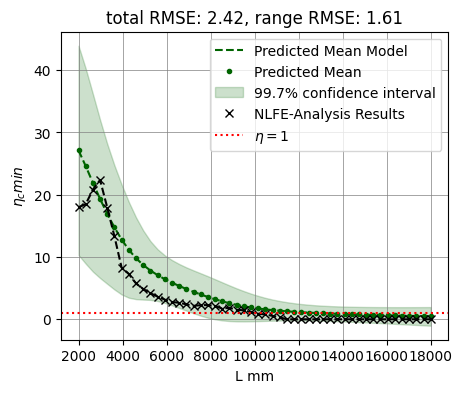

In [382]:
from plotting import single_para_strudy_perf

#x=torch.unsqueeze(x_tensor_1d[:, 2], dim=1).data.numpy()
variable='L'
unit='mm'
x=np.array(x_data_1d[variable]).reshape(-1,1)
y_pred=mean_values.reshape(-1,1)
y_true=y_tensor_1d.data.numpy()
y_std=std_values.reshape(-1,1)

single_para_strudy_perf(x, y_pred, y_true, y_std, variable=variable, unit=unit, rmse=rmse.item(),rmse_range=rmse_range.item())

##### t_p-Parameter study

In [383]:
#import validation data
df_1d_tp=pd.read_csv("TestData\\602_CFB_xy.csv")

x_data_1d=df_1d_tp[x_names]
x_tensor_1d=torch.tensor(x_data_1d.values, dtype=torch.float32)

y_data_1d=df_1d_tp[y_names]
y_tensor_1d = torch.tensor(y_data_1d.values,dtype=torch.float32)


x_tensor_1d

tensor([[5.8000e+03, 9.7200e+03, 2.0000e+02, 4.0000e+02, 2.5800e+03, 2.4000e+01,
         2.4000e+01, 1.2000e+01, 2.0000e+02, 1.4000e+01, 2.4000e+01, 2.0000e+02,
         1.2800e+01, 1.8179e-01, 5.0000e+00, 1.0000e+03],
        [5.8000e+03, 9.7200e+03, 2.2041e+02, 4.0000e+02, 2.5800e+03, 2.4000e+01,
         2.4000e+01, 1.2000e+01, 2.0000e+02, 1.4000e+01, 2.4000e+01, 2.0000e+02,
         1.2800e+01, 1.8179e-01, 5.0000e+00, 1.0000e+03],
        [5.8000e+03, 9.7200e+03, 2.4082e+02, 4.0000e+02, 2.5800e+03, 2.4000e+01,
         2.4000e+01, 1.2000e+01, 2.0000e+02, 1.4000e+01, 2.4000e+01, 2.0000e+02,
         1.2800e+01, 1.8179e-01, 5.0000e+00, 1.0000e+03],
        [5.8000e+03, 9.7200e+03, 2.6122e+02, 4.0000e+02, 2.5800e+03, 2.4000e+01,
         2.4000e+01, 1.2000e+01, 2.0000e+02, 1.4000e+01, 2.4000e+01, 2.0000e+02,
         1.2800e+01, 1.8179e-01, 5.0000e+00, 1.0000e+03],
        [5.8000e+03, 9.7200e+03, 2.8163e+02, 4.0000e+02, 2.5800e+03, 2.4000e+01,
         2.4000e+01, 1.2000e+01, 2.0000

In [384]:
## normalise imoirted data
# Convert tensors to numpy arrays
x_data_1d_to_scale = x_tensor_1d.numpy()


# Scale the validation data using the same scaler as for fitted for the trainings set
x_data_1d_scaled = scaler.transform(x_data_1d_to_scale)

# Convert the scaled arrays back to tensors
x_tensor_1d_scaled = torch.tensor(x_data_1d_scaled, dtype=torch.float32)


print(x_tensor_1d_scaled)
print(y_tensor_1d)

tensor([[ 2.3744e-01,  3.9531e-01, -6.5972e-05,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 2.3744e-01,  3.9531e-01,  2.0349e-02,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 2.3744e-01,  3.9531e-01,  4.0763e-02,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 2.3744e-01,  3.9531e-01,  6.1178e-02,  2.0002e-01,  1.9319e-01,
          7.0003e-01,  6.9997e-01,  9.9865e-02,  2.4992e-01,  1.9997e-01,
          7.0002e-01,  2.4997e-01, -4.8801e-01,  1.0217e-01,  5.5000e-01,
          5.8331e-01],
        [ 2.3744e-01

c:\Users\kuhnso\AppData\Local\anaconda3\envs\BNNs\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [385]:
from model import predict
mean_values, std_values=predict(model=model, x_scaled=x_tensor_1d_scaled, n=1000)

In [386]:
from model import RMSE

mean_values_tensor = torch.tensor(mean_values).unsqueeze(1)

rmse=RMSE(y_pred=mean_values_tensor, y_true=y_tensor_1d, verbalize=True)
rmse_range=RMSE(y_pred=mean_values_tensor, y_true=y_tensor_1d, y_range=(0,5), verbalize=True)


Root Mean Squared Error (RMSE): 6.240512847900391
A range is provided.
Root Mean Squared Error (RMSE): 3.5423126220703125


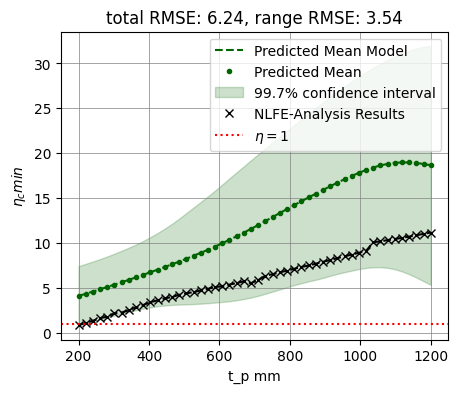

In [387]:
from plotting import single_para_strudy_perf

variable='t_p'
unit='mm'
x=np.array(x_data_1d[variable]).reshape(-1,1)
y_pred=mean_values.reshape(-1,1)
y_true=y_tensor_1d.data.numpy()
y_std=std_values.reshape(-1,1)

single_para_strudy_perf(x, y_pred, y_true, y_std, variable=variable, unit=unit, rmse=rmse.item(),rmse_range=rmse_range.item())